In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import pandas as pd
import numpy as np
from glob import glob
from os.path import join
from tqdm import tqdm
from matplotlib.colors import LogNorm

import strawb
from strawb.tools import wavelength_to_rgb

import seaborn as sns


In [3]:
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../no_git/style.mplstyle")
colorlist = plt.rcParams['axes.prop_cycle'].by_key()['color']


# Setup

In [4]:
# load DB
db = strawb.SyncDBHandler(file_name="Default")  # loads the db


In [5]:
### these are the available device codes
print(db.dataframe.deviceCode.unique())

### different measurement types for PMTSPEC and LIDAR
print(db.dataframe.measurement_type.unique())


['ONCMJB016' 'TUMLIDAR001' 'TUMLIDAR002' 'TUMMINISPECTROMETER001'
 'TUMMUONTRACKER001' 'TUMPMTSPECTROMETER001' 'TUMPMTSPECTROMETER002'
 'TUMSTANDARDMODULE001' 'TUMSTANDARDMODULE004']
[nan 'counts' 'rate_scan' 'basic']


## select time range

In [6]:
mask = db.dataframe["deviceCode"] == "TUMPMTSPECTROMETER001"
mask &= db.dataframe["dataProductCode"] == "PMTSD"

timestamp = np.datetime64("2021-09-01T00:00:00")
mask &= db.dataframe.dateFrom >= pd.Timestamp(np.datetime64(timestamp, "h"), tz="UTC")
mask &= db.dataframe.dateFrom < pd.Timestamp(
    np.datetime64(timestamp, "h"), tz="UTC"
) + np.timedelta64(5, "D")


In [7]:
### see which files are synced
np.count_nonzero(db.dataframe[mask].synced), len(db.dataframe[mask])


(130, 130)

set up a column to track which files are known to be ok, or which files are known to be eg. corrupt

if not "file_ok" in db.dataframe:
    db.dataframe["file_ok"] = "None"

## download missing files

In [8]:
# check if files will be downloaded
if not db.dataframe.synced[mask].all():
    print("Files will be downloaded")
else:
    print("No files will be downloaded")


No files will be downloaded


In [ ]:
### this will download the selected files
if not db.dataframe.synced[mask].all():
    db.update_db_and_load_files(
        db.dataframe[mask],
        output=True,  # print output to console
        download=True,  # download the files
        # save_db=True
    )
    db.save_db()


  In total: 130 files; skips synced: 27; size to download: 2.58 GB, from deviceCode: ['TUMPMTSPECTROMETER001']

-> Download the files from the ONC server
100%|██████████| 103/103 [21:14<00:00, 12.37s/file, i=TUMPMTSPECTROMETER001_20210905T230000.000Z-SDAQ-PMTSPEC.hdf5]
Downloaded - Directory: /data/straw_b/raw_module_data; Files: 103; Size: 2.8 GB; Time: 21 minutes; Speed: 2.2 MB/s

-> Update hdf5 attributes
100%|██████████| 103/103 [00:00<00:00, 288.05files/s, i=115]

-> Add to db


In [9]:
# mask by device
mask = db.dataframe["deviceCode"] == "TUMPMTSPECTROMETER001"
mask &= db.dataframe["dataProductCode"] == "PMTSD"

# and add mask by 'measurement_type'
mask &= db.dataframe.measurement_type.isnull() | (
    db.dataframe.measurement_type == "counts"
)
mask &= db.dataframe["synced"]


In [10]:
db.dataframe[mask].head()  # plot the table with available PMTSPEC files


,archiveLocation,archivedDate,compression,dataProductCode,dateFrom,dateTo,deviceCode,fileSize,filename,modifyDate,...,name,previous_file_id,rollover_interval,run_end,run_start,write_period,measurement_type,measurement_duration,write_period_jitter,file_ok
fullPath,,,,,,,,,,,,,,,,,,,,,
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T000000.000Z-SDAQ-PMTSPEC.hdf5,/NA_Archive_04,2021-09-01 02:09:41.650000+00:00,None,PMTSD,2021-09-01 00:00:00+00:00,2021-09-01 00:59:59.999000+00:00,TUMPMTSPECTROMETER001,31861355,TUMPMTSPECTROMETER001_20210901T000000.000Z-SDA...,2021-09-01 02:09:43.402000+00:00,...,PMTSPEC,3.622651e+18,{'hours': 1},NaT,2021-08-31 03:08:04.986227036+00:00,60.0,counts,NaN,NaN,ok
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T010000.000Z-SDAQ-PMTSPEC.hdf5,/NA_Archive_04,2021-09-02 01:50:13.216000+00:00,None,PMTSD,2021-09-01 01:00:00+00:00,2021-09-01 01:59:59.999000+00:00,TUMPMTSPECTROMETER001,17324748,TUMPMTSPECTROMETER001_20210901T010000.000Z-SDA...,2021-09-02 01:50:13.720000+00:00,...,PMTSPEC,1.508277e+19,{'hours': 1},NaT,2021-08-31 03:08:04.986227036+00:00,60.0,counts,NaN,NaN,ok
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T020000.000Z-SDAQ-PMTSPEC.hdf5,/NA_Archive_04,2021-09-02 01:50:16.651000+00:00,None,PMTSD,2021-09-01 02:00:00+00:00,2021-09-01 02:59:59.999000+00:00,TUMPMTSPECTROMETER001,46204,TUMPMTSPECTROMETER001_20210901T020000.000Z-SDA...,2021-09-02 01:50:16.678000+00:00,...,PMTSPEC,1.705897e+19,{'hours': 1},NaT,2021-08-31 03:08:04.986227036+00:00,60.0,counts,NaN,NaN,corrupt
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T030000.000Z-SDAQ-PMTSPEC.hdf5,/NA_Archive_04,2021-09-02 01:50:32.796000+00:00,None,PMTSD,2021-09-01 03:00:00+00:00,2021-09-01 03:01:00.243000+00:00,TUMPMTSPECTROMETER001,39994,TUMPMTSPECTROMETER001_20210901T030000.000Z-SDA...,2021-09-02 01:50:32.815000+00:00,...,PMTSPEC,1.411401e+19,{'hours': 1},NaT,2021-08-31 03:08:04.986227036+00:00,60.0,counts,NaN,NaN,corrupt
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T030758.986Z-SDAQ-PMTSPEC.hdf5,/NA_Archive_04,2021-09-02 01:50:34.810000+00:00,None,PMTSD,2021-09-01 03:07:58.986000+00:00,2021-09-01 03:59:59.999000+00:00,TUMPMTSPECTROMETER001,26586245,TUMPMTSPECTROMETER001_20210901T030758.986Z-SDA...,2021-09-02 01:50:35.488000+00:00,...,PMTSPEC,0.000000e+00,{'hours': 1},NaT,2021-09-01 03:07:58.987215042+00:00,60.0,counts,NaN,NaN,ok


In [11]:
db.dataframe[mask]["file_ok"].head()


fullPath
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T000000.000Z-SDAQ-PMTSPEC.hdf5         ok
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T010000.000Z-SDAQ-PMTSPEC.hdf5         ok
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T020000.000Z-SDAQ-PMTSPEC.hdf5    corrupt
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T030000.000Z-SDAQ-PMTSPEC.hdf5    corrupt
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T030758.986Z-SDAQ-PMTSPEC.hdf5         ok
Name: file_ok, dtype: object

# Rate counting

## load or read data

In [12]:
good_trb_series = pd.read_pickle(
    "/data/straw_b/processed_data/pmtspectrometer001/dataframes/20210901_good_trb_series.pickle"
)


In [50]:
good_trb_series = []
# select file with the right data
mask = db.dataframe.deviceCode == "TUMPMTSPECTROMETER001"
mask &= db.dataframe.dataProductCode == "PMTSD"
mask &= db.dataframe.measurement_type.isnull() | (
    db.dataframe.measurement_type == "counts"
)
# only synced data
mask &= db.dataframe.synced
# load PMTSpec
for i, row in db.dataframe[mask].iterrows():
    if row.file_ok == "corrupt" or row.file_ok == "empty":
        continue
    try:
        ## get the PMT data and its meta data (channel no. etc)
        pmt_specs_timeseries = strawb.sensors.PMTSpec(row.filename)
        meta = pmt_specs_timeseries.pmt_meta_data.channel_meta_array

        ## select the channel with no wavelength filter
        no_filter_ind = meta[meta["wavelength"] == 0]["index"][0]
        selection = pmt_specs_timeseries.trb_rates.rate[no_filter_ind]

    except KeyError:
        # corrupt file
        print("Corrupt file:", row.filename)
        db.dataframe.loc[i, "file_ok"] = "corrupt"
        continue
    except TypeError as e:
        # empty file
        print("Empty file:", row.filename)
        db.dataframe.loc[i, "file_ok"] = "empty"
        continue
    
    ## build a histogram of the rate series
    bins = np.linspace(1, 8, 100)
    h, ed = np.histogram(np.log10(selection[selection > 0]), bins=bins)
    ## ... and a histogram weighted with the size of the time intervals
    ## TODO: add ZERO underflow bin
    hw, _ = np.histogram(
        np.log10(selection[selection > 0]),
        bins=bins,
        weights=pmt_specs_timeseries.trb_rates._rate_delta_t[selection > 0],
    )
    good_trb_series.append(
        {
            "rate_hist": h,
            "weighted_rate_hist": hw,
            "rate_bins": ed,
            "zero_counts": np.count_nonzero(selection == 0),
            "timestamp": pd.Timestamp(row.dateFrom),
        }
    )
    db.dataframe.loc[i, "file_ok"] = "ok"
good_trb_series = pd.DataFrame(good_trb_series)
db.save_db()
good_trb_series.to_pickle(
    "/data/straw_b/processed_data/pmtspectrometer001/dataframes/20210901_good_trb_series.pickle"
)


In [22]:
db.dataframe[
    (db.dataframe.file_ok == "corrupt") | (db.dataframe.file_ok == "empty")
].fileSize


fullPath
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T020000.000Z-SDAQ-PMTSPEC.hdf5    46204
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T030000.000Z-SDAQ-PMTSPEC.hdf5    39994
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210926T030000.000Z-SDAQ-PMTSPEC.hdf5    39999
Name: fileSize, dtype: int64

## rate plots

Text(0.5, 1.0, '2021-09-01 00:00:00+00:00 - 2021-09-26 03:08:14.505000+00:00')

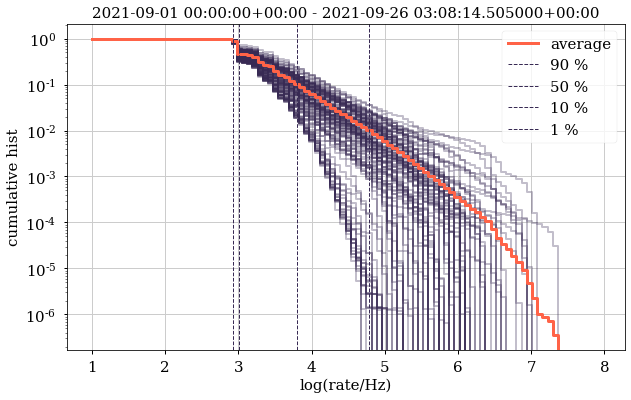

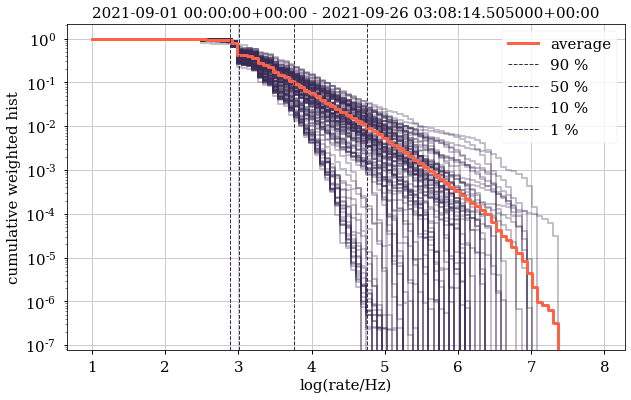

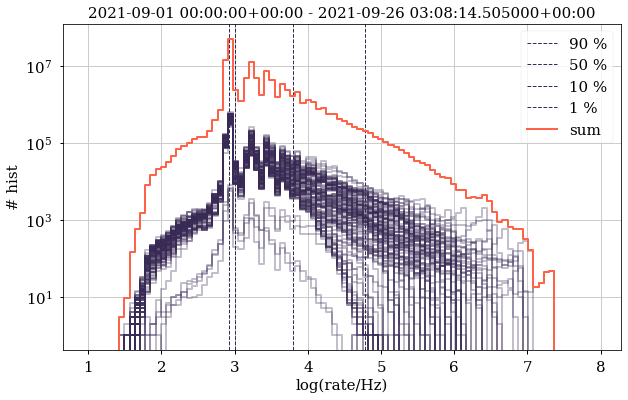

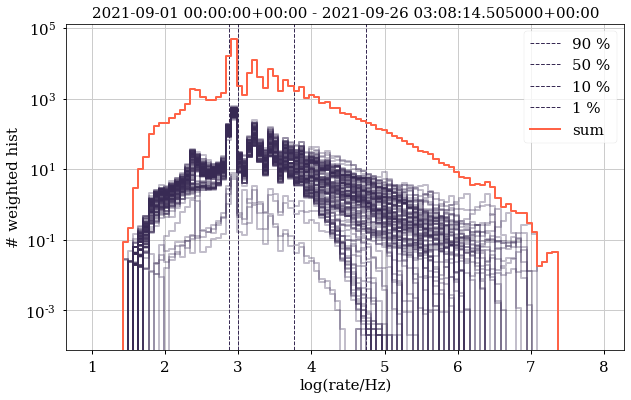

In [21]:
## total rates, cumulative rates, per hour
plt.figure(1, figsize=(10, 6))
plt.figure(2, figsize=(10, 6))
plt.figure(3, figsize=(10, 6))
plt.figure(4, figsize=(10, 6))

for _, trb in good_trb_series.iterrows():
    plt.figure(1)
    cs = np.cumsum(trb.rate_hist[::-1]).astype(float)
    cs /= cs[-1]
    plt.plot(
        trb.rate_bins[:-1],
        cs[::-1],
        ds="steps-pre",
        # , label=trb.timestamp)
        alpha=0.3,
        color=colorlist[0]
    )

    plt.figure(2)
    cs = np.cumsum(trb.weighted_rate_hist[::-1]).astype(float)
    cs /= cs[-1]
    plt.plot(
        trb.rate_bins[:-1],
        cs[::-1],
        ds="steps-pre",
        # , label=trb.timestamp)
        alpha=0.3,
        color=colorlist[0]
    )

    plt.figure(3)
    plt.plot(
        trb.rate_bins[:-1],
        trb.rate_hist,
        # label=timestamp,
        color=colorlist[0],
        ds="steps",
        alpha=0.3
    )
    # plt.scatter(-0.5 + 0.1 * _, trb.zero_counts, color=p[0].get_color())

    plt.figure(4)
    plt.plot(
        trb.rate_bins[:-1],
        trb.weighted_rate_hist,
        # label=timestamp,
        color=colorlist[0],
        ds="steps",
        alpha=0.3
    )
    # plt.scatter(-0.5 + 0.1 * _, trb.zero_counts, color=p[0].get_color())

rate_sum = good_trb_series.rate_hist.sum()
weighted_rate_sum = good_trb_series.weighted_rate_hist.sum()

plt.figure(1)
cs = np.cumsum(rate_sum[::-1]).astype(float)
cs /= cs[-1]
p = plt.plot(
    trb.rate_bins[:-1], cs[::-1], ds="steps-pre", label="average", color="tomato", lw=3
)


plt.figure(2)
wcs = np.cumsum(weighted_rate_sum[::-1]).astype(float)
wcs /= wcs[-1]
p = plt.plot(
    trb.rate_bins[:-1], wcs[::-1], ds="steps-pre", label="average", color="tomato", lw=3
)

quantiles = [0.9, 0.5, 0.1, 0.01]
for q in quantiles:
    mids = (trb.rate_bins[:-1] + trb.rate_bins[1:]) * 0.5
    mask = cs[::-1] >= q
    x1 = mids[mask][-2]; x2 = mids[mask][-1]
    y1 = cs[::-1][mask][-1]; y2 = cs[::-1][~mask][0]
    thresh = np.interp(q, [y2, y1], [x2, x1])
    plt.figure(1)
    plt.axvline(thresh, label=f"{int(q*100)} %", ls="--", lw=1)
    plt.figure(3)
    plt.axvline(thresh, label=f"{int(q*100)} %", ls="--", lw=1)

    mask = wcs[::-1] >= q
    x1 = mids[mask][-2]; x2 = mids[mask][-1]
    y1 = wcs[::-1][mask][-1]; y2 = wcs[::-1][~mask][0]
    thresh = np.interp(q, [y2, y1], [x2, x1])
    plt.figure(2)
    plt.axvline(thresh, label=f"{int(q*100)} %", ls="--", lw=1)
    plt.figure(4)
    plt.axvline(thresh, label=f"{int(q*100)} %", ls="--", lw=1)

plt.figure(3)
plt.plot(
    trb.rate_bins[:-1],
    rate_sum,
    label="sum",
    color=p[0].get_color(),
    ds="steps",
)
# plt.scatter(-0.5 + 0.1 * (_ + 1), trb.zero_counts, color="tomato")

plt.figure(4)
plt.plot(
    trb.rate_bins[:-1],
    weighted_rate_sum,
    label="sum",
    color=p[0].get_color(),
    ds="steps",
)
# plt.scatter(-0.5 + 0.1 * (_ + 1), trb.zero_counts, color="tomato")


plt.figure(1)
plt.ylabel("cumulative hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=1, ncol=1)
#plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1)
plt.semilogy()
plt.title(f"{good_trb_series.timestamp.min()} - {good_trb_series.timestamp.max()}")

plt.figure(2)
plt.ylabel("cumulative weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=1, ncol=1)
#plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1)
plt.semilogy()
plt.title(f"{good_trb_series.timestamp.min()} - {good_trb_series.timestamp.max()}")

plt.figure(3)
plt.ylabel("# hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=1, ncol=1)
#plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1)
plt.semilogy()
plt.title(f"{good_trb_series.timestamp.min()} - {good_trb_series.timestamp.max()}")

plt.figure(4)
plt.ylabel("# weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=1, ncol=1)
#plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1)
plt.semilogy()
plt.title(f"{good_trb_series.timestamp.min()} - {good_trb_series.timestamp.max()}")


In [53]:
## percentiles of rate per hour
# plt.figure(1, figsize=(10, 6))

quantiles = [0.5, 0.1, 0.01]
quantile_values = []

for _, trb in good_trb_series.iterrows():
    cs = np.cumsum(trb.rate_hist[::-1]).astype(float)
    cs /= cs[-1]
    tmp = {"timestamp": trb.timestamp}
    for q in quantiles:
        mids = (trb.rate_bins[:-1] + trb.rate_bins[1:]) * 0.5
        tmp[f"q_{int(q*100)}"] = mids[cs[::-1] >= q][-1]

    cs = np.cumsum(trb.weighted_rate_hist[::-1]).astype(float)
    cs /= cs[-1]
    for q in quantiles:
        mids = (trb.rate_bins[:-1] + trb.rate_bins[1:]) * 0.5
        tmp[f"q_{int(q*100)}_weighted"] = mids[cs[::-1] >= q][-1]
    quantile_values.append(tmp)
quantile_values = pd.DataFrame(quantile_values)
quantile_values

,timestamp,q_50,q_10,q_1,q_50_weighted,q_10_weighted,q_1_weighted
0,2021-09-01 00:00:00+00:00,3.227273,4.075758,5.065657,3.156566,4.005051,5.065657
1,2021-09-01 01:00:00+00:00,3.297980,4.146465,4.924242,3.297980,4.146465,4.853535
2,2021-09-01 03:07:58.986000+00:00,3.227273,4.075758,4.853535,3.015152,4.005051,4.782828
3,2021-09-01 04:00:00+00:00,3.015152,3.510101,4.146465,3.015152,3.510101,4.075758
4,2021-09-01 05:00:00+00:00,3.015152,3.510101,3.934343,3.015152,3.510101,3.934343
...,...,...,...,...,...,...,...
120,2021-09-05 21:00:00+00:00,3.015152,3.651515,4.429293,3.015152,3.651515,4.429293
121,2021-09-05 22:00:00+00:00,3.015152,3.510101,4.005051,3.015152,3.510101,4.005051
122,2021-09-05 23:00:00+00:00,3.015152,3.722222,4.429293,3.015152,3.651515,4.429293
123,2021-09-14 12:00:00+00:00,3.297980,4.075758,4.994949,3.297980,4.005051,4.924242


In [62]:
timestamp = np.datetime64("2021-09-06T00:00:00")
quantile_values.timestamp <= pd.Timestamp(timestamp, tz="utc")

0       True
1       True
2       True
3       True
4       True
       ...  
120     True
121     True
122     True
123    False
124    False
Name: timestamp, Length: 125, dtype: bool

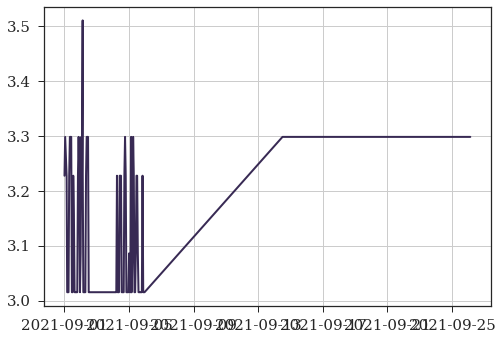

In [43]:
plt.plot(quantile_values.timestamp, quantile_values.q_50)

In [ ]:
rate_sum = good_trb_series.rate_hist.sum()
weighted_rate_sum = good_trb_series.weighted_rate_hist.sum()

cs = np.cumsum(rate_sum[::-1]).astype(float)
cs /= cs[-1]
wcs = np.cumsum(weighted_rate_sum[::-1]).astype(float)
wcs /= wcs[-1]

for q in quantiles:
    mids = (trb.rate_bins[:-1] + trb.rate_bins[1:]) * 0.5
    thresh = mids[cs[::-1] >= q][-1]
    plt.figure(1)
    plt.axvline(thresh, label=f"{q*100} %", ls="--", lw=1)
    plt.figure(3)
    plt.axvline(thresh, label=f"{q*100} %", ls="--", lw=1)

    thresh = mids[wcs[::-1] >= q][-1]
    plt.figure(2)
    plt.axvline(thresh, label=f"{q*100} %", ls="--", lw=1)
    plt.figure(4)
    plt.axvline(thresh, label=f"{q*100} %", ls="--", lw=1)


plt.ylabel("# weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=1, ncol=1)
#plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1)
plt.semilogy()
plt.title(f"{good_trb_series.timestamp.min()} - {good_trb_series.timestamp.max()}")


# Analyze specific events

In [16]:
selected_timestamps = [
    np.datetime64("2021-09-04T23:44:09"),
    np.datetime64("2021-09-14T12:11:46"),
    np.datetime64("2021-09-26T03:14:35"),
]


In [17]:
for timestamp in selected_timestamps:
    mask = db.dataframe["deviceCode"] == "TUMPMTSPECTROMETER001"
    mask &= db.dataframe["dataProductCode"] == "PMTSD"
    ## select 1h frame around the selected timestamps
    mask &= db.dataframe.dateFrom >= pd.Timestamp(
        np.datetime64(timestamp, "h"), tz="UTC"
    )
    mask &= db.dataframe.dateFrom < (pd.Timestamp(
        np.datetime64(timestamp, "h"), tz="UTC"
    ) + np.timedelta64(1, "h"))
    if not db.dataframe.synced[mask].all():
        db.update_db_and_load_files(
            db.dataframe[mask],
            output=True,  # print output to console
            download=True,  # download the files
            # save_db=True
        )
        db.save_db()


In [18]:
pmt_specs = []
for timestamp in selected_timestamps:
    # select file with the right data
    mask = db.dataframe.deviceCode == "TUMPMTSPECTROMETER001"
    mask &= db.dataframe.dataProductCode == "PMTSD"
    mask &= db.dataframe.measurement_type.isnull() | (
        db.dataframe.measurement_type == "counts"
    )
    # only synced data
    mask &= db.dataframe.synced

    ## select 1h frame around the biolumi event
    mask &= db.dataframe.dateFrom >= pd.Timestamp(
        np.datetime64(timestamp, "h"), tz="UTC"
    )
    mask &= db.dataframe.dateFrom < pd.Timestamp(
        np.datetime64(timestamp, "h"), tz="UTC"
    ) + np.timedelta64(1, "h")

    # load PMTSpec
    try:
        # select the latest frame that matches the condition
        pmt_specs.append(strawb.sensors.PMTSpec(db.dataframe.filename[mask].iloc[-1]))
        print("that did actually work!")
    except:
        print("that didnt work", db.dataframe.filename[mask].iloc[-1])
        continue


that did actually work!
that did actually work!
that did actually work!


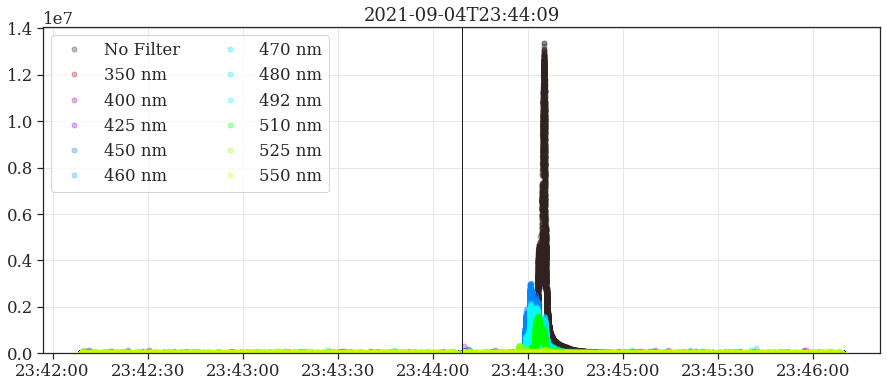

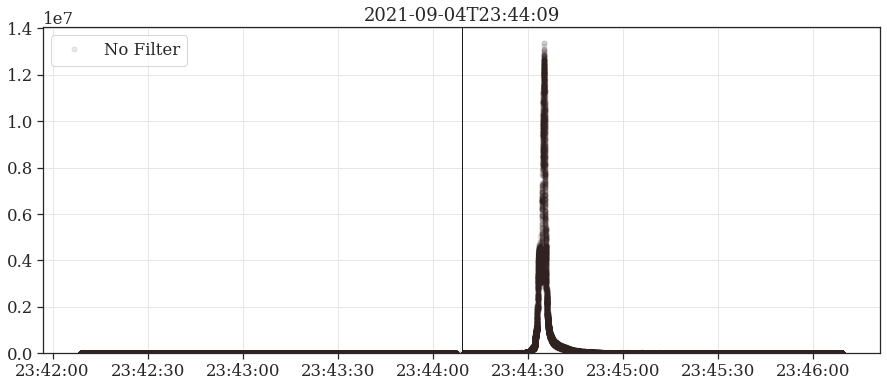

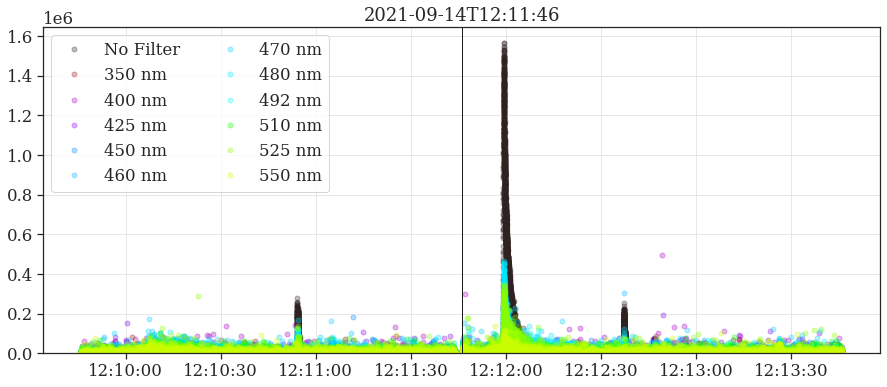

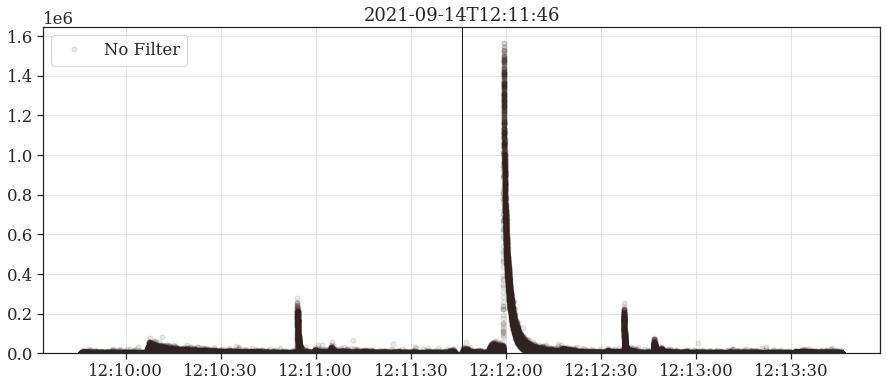

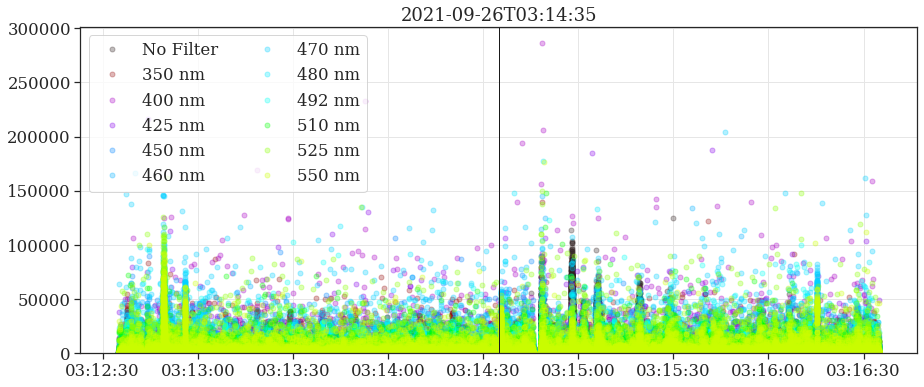

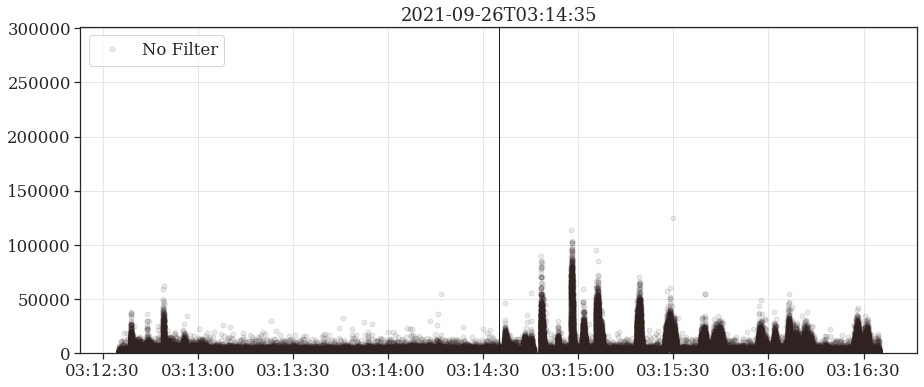

In [19]:
for pmtspec, timestamp in zip(pmt_specs, selected_timestamps):

    pmtspec.pmt_meta_data.add_colors(
        plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
    )

    times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
    ### select +-2min around biolumi events
    timemask = times_ns >= timestamp - np.timedelta64(
        2, "m"
    )  # - np.timedelta64(30, "s")
    timemask &= times_ns <= timestamp + np.timedelta64(
        2, "m"
    )  # + np.timedelta64(30, "s")
    masked_times_ns = times_ns[timemask]

    plt.figure(figsize=(15, 6))
    plt.title(timestamp)
    for ch in pmtspec.pmt_meta_data.channel_meta_array:
        _ = plt.plot(
            masked_times_ns,
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
            color=wavelength_to_rgb(ch, gamma=0.4),
            label=ch["label"],
            marker="o",
            lw=0,
            alpha=0.3,
            ms=5,
        )
    plt.legend(loc=2, ncol=2)
    plt.axvline(timestamp, lw=1, color="k")
    plt.ylim(0, np.max(pmtspec.trb_rates.rate.T[timemask]) * 1.05)

    plt.figure(figsize=(15, 6))
    plt.title(timestamp)
    for ch in pmtspec.pmt_meta_data.channel_meta_array[
        pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
    ]:
        _ = plt.plot(
            masked_times_ns,
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
            color=wavelength_to_rgb(ch, gamma=0.4),
            label=ch["label"],
            marker="o",
            lw=0,
            alpha=0.1,
            ms=5,
        )
    plt.legend(loc=2, ncol=2)
    plt.axvline(timestamp, lw=1, color="k")
    plt.ylim(0, np.max(pmtspec.trb_rates.rate.T[timemask]) * 1.05)

## zoom ins

In [20]:
import colorsys
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.colors as mc


In [21]:
def change_color_ld(color, amount=0.2):
    """slightly change the color lightness/darkness"""
    if not colorsys:
        print("Cannot change color.")
        return color
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    c_new = np.clip(c[1] + amount, 0, 1)
    return colorsys.hls_to_rgb(c[0], c_new, c[2])


In [22]:
filter_N = 100


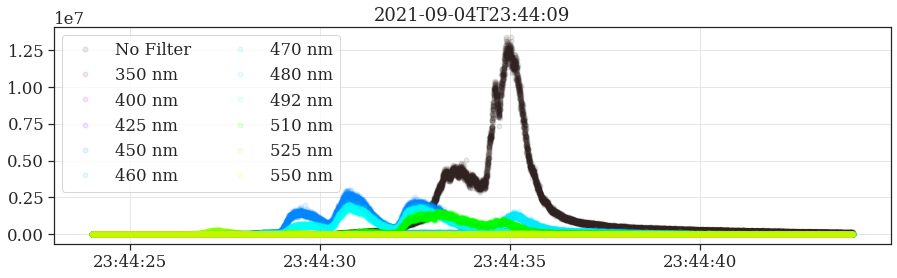

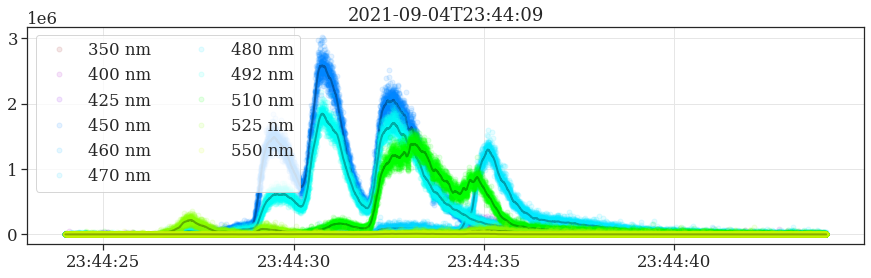

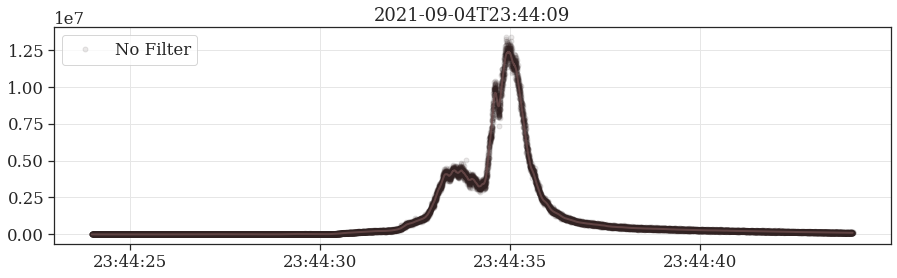

In [23]:
pmtspec, timestamp = pmt_specs[0], selected_timestamps[0]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
### select +-2min around biolumi events
timemask = times_ns >= timestamp + np.timedelta64(15, "s")
timemask &= times_ns <= timestamp + np.timedelta64(35, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=2, ncol=2)

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] != 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
    plt.plot(
        masked_times_ns,
        uniform_filter1d(
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]], size=filter_N
        ),
        color=change_color_ld(wavelength_to_rgb(ch, gamma=0.4), -0.2),
        lw=2,
        alpha=0.8,
    )
plt.legend(loc=2, ncol=2)

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
    plt.plot(
        masked_times_ns,
        uniform_filter1d(
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]], size=filter_N
        ),
        color=change_color_ld(wavelength_to_rgb(ch, gamma=0.4), +0.2),
        lw=2,
        alpha=0.8,
    )
plt.legend(loc=2, ncol=2)


# Find peaks and quantify

In [24]:
from scipy.signal import find_peaks
filter_N = 100


[]

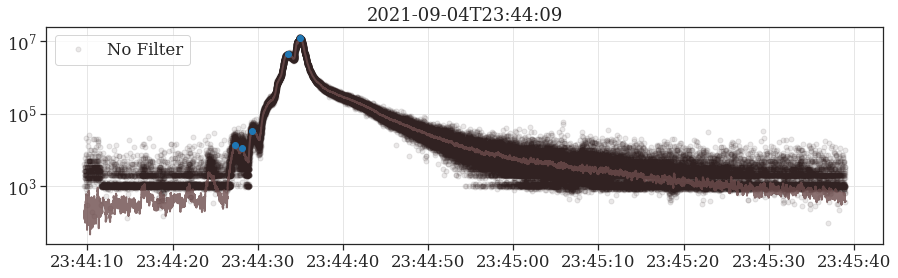

In [25]:
pmtspec, timestamp = pmt_specs[0], selected_timestamps[0]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
timemask = times_ns >= timestamp + np.timedelta64(0, "s")
timemask &= times_ns <= timestamp + np.timedelta64(90, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
    smoothed_rate = uniform_filter1d(
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]], size=filter_N
    )
    plt.plot(
        masked_times_ns,
        smoothed_rate,
        color=change_color_ld(wavelength_to_rgb(ch, gamma=0.4), +0.2),
        lw=2,
        alpha=0.8,
    )
    peaks, prop = find_peaks(
        smoothed_rate,
        height=1e4,
        width=filter_N,
        distance=filter_N,
        rel_height=0.3
        # prominence=8E3
    )
    plt.plot(masked_times_ns[peaks], smoothed_rate[peaks], marker="o", lw=0, color="tab:blue")
plt.legend(loc=2, ncol=2)
plt.semilogy()


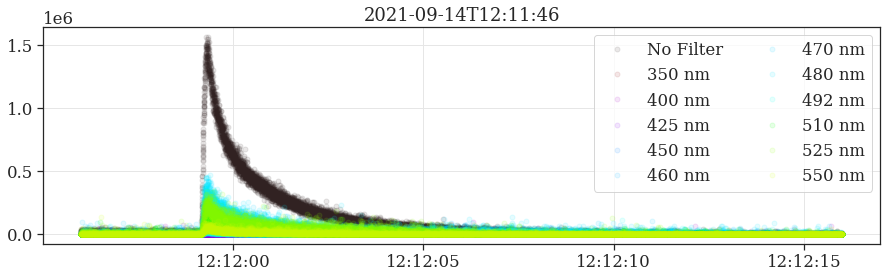

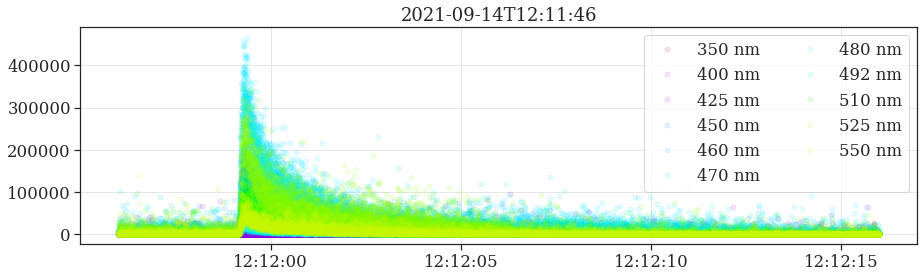

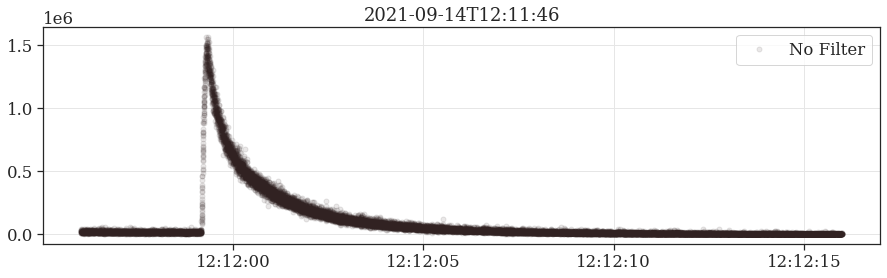

In [26]:
pmtspec, timestamp = pmt_specs[1], selected_timestamps[1]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
### select +-2min around biolumi events
timemask = times_ns >= timestamp + np.timedelta64(10, "s")
timemask &= times_ns <= timestamp + np.timedelta64(30, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] != 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


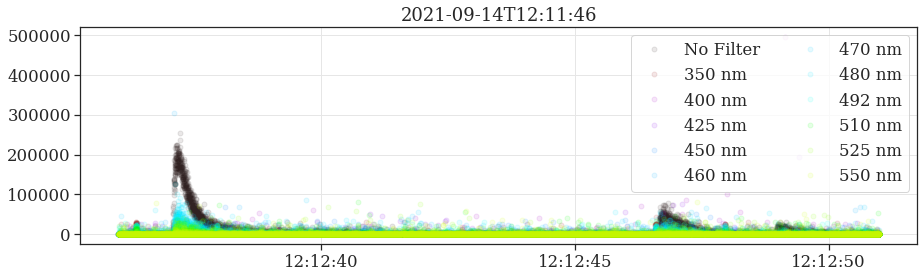

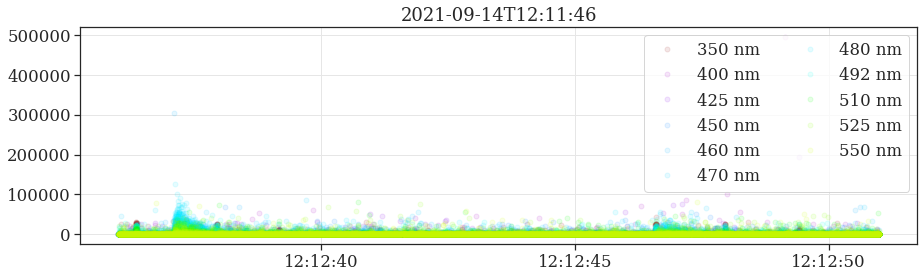

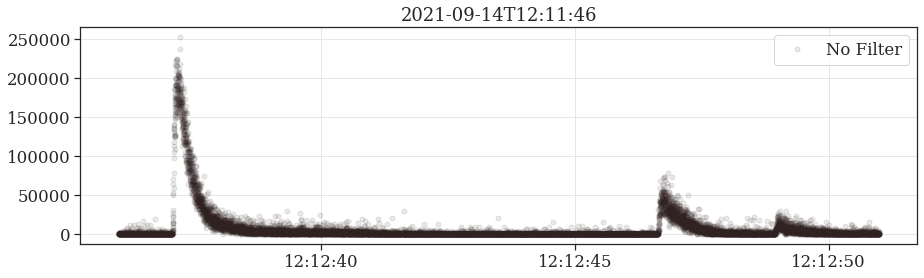

In [27]:
pmtspec, timestamp = pmt_specs[1], selected_timestamps[1]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
### select +-2min around biolumi events
timemask = times_ns >= timestamp + np.timedelta64(50, "s")
timemask &= times_ns <= timestamp + np.timedelta64(65, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] != 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


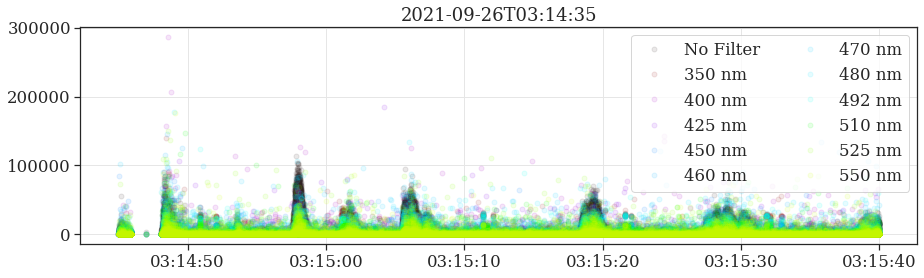

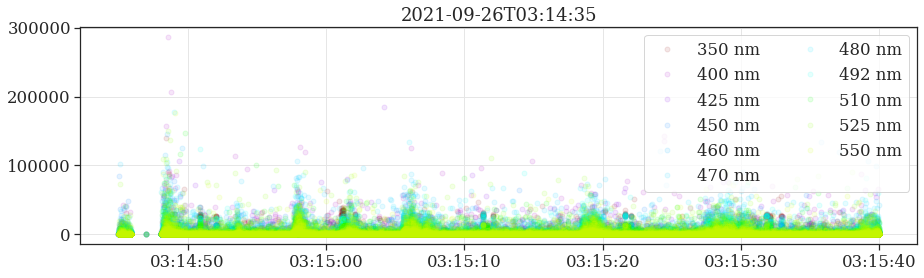

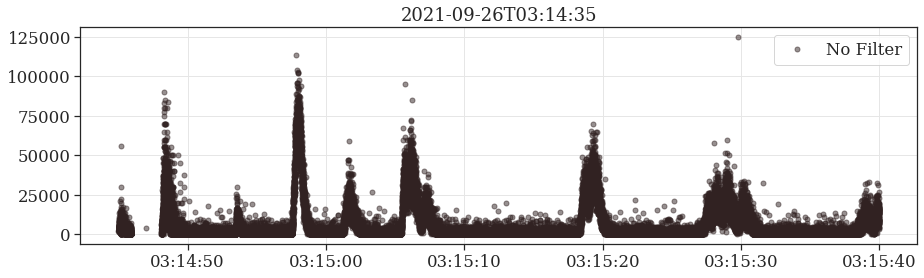

In [28]:
pmtspec, timestamp = pmt_specs[2], selected_timestamps[2]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
### select +-2min around biolumi events
timemask = times_ns >= timestamp + np.timedelta64(10, "s")
timemask &= times_ns <= timestamp + np.timedelta64(65, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] != 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.5,
        ms=5,
    )
plt.legend(loc=1, ncol=2)
